In [18]:
# Import Packages:
from __future__ import print_function

import os, sys
from six.moves import cPickle as pickle
from six.moves import range
from collections import defaultdict


# Model Packages import
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Get the current working directory
cwd = os.getcwd()
mydir = os.path.abspath(os.path.join(cwd, ".."))
sys.path.append(mydir)
from DataGenerator import genTrainValidFolds


# Packages for plot:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [19]:
STDbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/STD/batchData/"
EDGbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/EDG/batchData/"
HOGp1batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp1/batchData/"   # dim =162
HOGp2batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp2/batchData/"   # dim =576
HOGp3batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp3/batchData/"

featureDIR = STDbatch_dir

In [20]:
def reset_graph():  # Reset the graph
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
    
    
def reshape_data(dataset, labels=None, imageSize=32, numChannels=1, sample_size=None):
    if sample_size:
        dataset = dataset[:sample_size].reshape((-1,imageSize,imageSize,numChannels)) # To reshape the
        # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
        if labels:
            numLabels = len(np.unique(labels))
            labels = (np.arange(numLabels) == labels[:,None]).astype(np.float32)
    else:
        dataset = dataset.reshape((-1,imageSize,imageSize,numChannels)) # To reshape the  
        # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
        if labels:
            numLabels = len(np.unique(labels))
            labels = (np.arange(numLabels) == labels[:,None]).astype(np.float32)
    return dataset, labels

In [21]:
def accuracy(predictions, labels):
    # Both the predictions and the labels should be in One-Hot vector format.
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])


def confusionMatrix(predictions, labels):
    # Both the predictions and the labels should be in One-Hot vector format.
    return (pd.crosstab(np.argmax(labels, 1), np.argmax(predictions, 1), rownames=['True'], colnames=['Predicted'], margins=True))

In [22]:
class GlabalVariables(object):
    
    def __init__(self):
        super(GlabalVariables, self).__init__()

        self.imageSize = 32
        self.seed = 2316                 # Set the seeds for the random weights generator
        self.numFolds = 10
        
        # Network Parameters
        self.numLabels = 2
        self.numChannel = 1              # numChannels -> For grayscale =1, for RGB =3
        self.numHidden1 = 1024           # numHiddenUnits for the fully connected layerr
        self.numHidden2 = 1024           # numHiddenUnits for the fully connected layer

        self.conv1Kernel = 5             # Size of kernel for the first convolution layer
        self.conv2Kernel = 5             # Size of kernel for the second convolution layer
        self.conv1Depth = 64             # Number of kernels for the first convolution layer
        self.conv2Depth = 64             # Number of kernels for the second convolution layer
        self.conv1Stride = 1             # Strides for the first convolution layer filter  
        self.conv2Stride = 1             # Strides for the second convolution layer filter

        self.pool1Kernel = 2             # Size of kernel for the first Pooling layer
        self.pool2Kernel = 2             # Size of kernel for the second Pooling layer  
        self.pool1Stride = 2             # Strides for the first Pooling layer filter
        self.pool2Stride = 2             # Strides for the second Pooling layer filter
        
        # Learning Variables     
        self.epochs = 10
        self.batchSize = 500
        
        # Learning Parameters;
#         self.alpha = 0.003               # The learning Rate, A high Learning Rate will would be inefficient. If using higher
#                                          # learning rate then use regularizer else, the model will overfitt
#         self.dropout = 0.75              # Drop out a weight with a probability
#         self.momentum = 0.5              # Momentum for optimization if using momentem if using momentum optimizer
        
        

In [23]:
# class BuildConvNet(GlabalVariables):
    
#     def __init__(self):
#         super(BuildConvNet, self).__init__()
        
#         self.weights = {
#             'cv1_wght': tf.Variable(tf.random_normal([self.conv1Kernel, self.conv1Kernel, self.numChannel, self.conv1Depth], seed=8753)),
#             'cv2_wgth': tf.Variable(tf.random_normal([self.conv2Kernel, self.conv2Kernel, self.conv1Depth, self.conv2Depth], seed=3521)),
#             'fc2_wght': tf.Variable(tf.random_normal([self.numHidden1, self.numHidden2], seed=9777)),
#             'out_wght': tf.Variable(tf.random_normal([self.numHidden2, self.numLabels], seed=6467))
#         }

#         self.biases = {
#             'cv1_bias': tf.Variable(tf.random_normal([self.conv1Depth], seed=8767)),
#             'cv2_bias': tf.Variable(tf.random_normal([self.conv2Depth], seed=9887)),
#             'fc1_bias': tf.Variable(tf.random_normal([self.numHidden1], seed=4323)),
#             'fc2_bias': tf.Variable(tf.random_normal([self.numHidden2], seed=4348)),
#             'out_bias': tf.Variable(tf.random_normal([self.numLabels], seed=9878))
#         }


#     def convLayer(self, x, w, b, s=1, nlModel='RELU'):
#         x = tf.nn.conv2d(x, w, [1,s,s,1], padding='SAME') # Same padding
#         x = tf.nn.bias_add(x, b)
#         if nlModel == 'RELU':
#             return tf.nn.relu(x)
#         elif nlModel == 'LOGIT':
#             return tf.sigmoid(x)


#     def poolLayer(self, x, k=2, s=2, poolType='MAX'):
#         if poolType=='MAX':
#             return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')
#         elif poolType == 'AVG':
#             return tf.nn.avg_pool(data, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')

        
#     def fcLayer(self, x, w, b, keepProb=None, nModel='RELU'):
#         x = tf.matmul(x, w) + b
#         if nModel=='RELU':
#             x = tf.nn.relu(x)
#         if nModel=='LOGIT':
#             x = tf.sigmoid(x)
#         if keepProb:
#             return tf.nn.dropout(x, keepProb, seed=6162)
#         else:
#             return x
        
        
#     def outputLayer(self, x, w, b):
#         x = tf.matmul(x, w) + b
#         return x, tf.nn.softmax(x)
    
            
#     # Convolutional Layer (Includes the convLayer and the max pool layer)
# #     def convFeatureExtractor(self, x):
# #         # Convolution and Pooling Layer 1
# #         conv1 = self.convLayer(x, self.weights['cv1_wght'], self.biases['cv1_bias'], s=self.conv1Stride)
# #         conv1 = self.poolLayer(conv1, k=self.pool1Kernel)

# #         # Convolution and Pooling Layer 2
# #         conv2 = self.convLayer(conv1, self.weights['cv2_wgth'], self.biases['cv2_bias'], self.conv2Stride)
# #         conv2 = self.poolLayer(conv2, k=self.pool2Kernel)
        
# #         # Get the features in flattened fashion
# #         poolShape = conv2.get_shape().as_list()[1]
# #         numConvFeatures = poolShape*poolShape*self.conv2Depth
# #         convFeatures = tf.reshape(conv2, [-1, numConvFeatures])
        
# #         return convFeatures, numConvFeatures
        
        
#     # Create the training Graph Lineage
#     def trainGraph(self):
#         trainData = tf.placeholder(tf.float32, [None, self.imageSize, self.imageSize, self.numChannel])
#         trainLabels = tf.placeholder(tf.float32, [None, self.numLabels])

#         # Convolutional Layer
#         # Convolution and Pooling Layer 1
#         conv1 = self.convLayer(trainData, self.weights['cv1_wght'], self.biases['cv1_bias'], s=self.conv1Stride)
#         conv1 = self.poolLayer(conv1, k=self.pool1Kernel)

#         # Convolution and Pooling Layer 2
#         conv2 = self.convLayer(conv1, self.weights['cv2_wgth'], self.biases['cv2_bias'], self.conv2Stride)
#         conv2 = self.poolLayer(conv2, k=self.pool2Kernel)
        
#         # Get the features in flattened fashion
#         poolShape = conv2.get_shape().as_list()[1]
#         numConvFeatures = poolShape*poolShape*self.conv2Depth
#         convFeatures = tf.reshape(conv2, [-1, numConvFeatures])
        
        
#         # Fully connected layer : Reshape conv2 output to fit fully connected layer input
#         self.weights['fc1_wght'] =  tf.Variable(tf.random_normal([numConvFeatures, self.numHidden1], seed=6663))
#         fc1State = self.fcLayer(convFeatures, self.weights['fc1_wght'], self.biases['fc1_bias'], keepProb=0.75, nModel='RELU')
        
#         # Fully connected layer : Layer 2
#         fc2State = self.fcLayer(fc1State, self.weights['fc2_wght'], self.biases['fc2_bias'], keepProb=0.75, nModel='RELU')

#         # Output, or the Softmax layer
#         pred, outputState = self.outputLayer(fc2State, self.weights['out_wght'], self.biases['out_bias'])
        
#         # Loss function and Optimization
#         lossCE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=trainLabels))
# #         optimizer = tf.train.AdamOptimizer(learning_rate=0.003).minimize(lossCE)
#         optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0008, momentum=0.8).minimize(lossCE)

        
#         return dict(
#             trainData=trainData, 
#             trainLabels=trainLabels, 
#             optimizer=optimizer, 
#             lossCE=lossCE,
#             trainPred = outputState,
#             wghtNew = self.weights
#         )
    
    
#     # Create the Validation Graph Lineage
#     def validGraph(self):

#         validData = tf.placeholder(tf.float32, [None, self.imageSize, self.imageSize, self.numChannel])
#         validLabels = tf.placeholder(tf.float32, [None, self.numLabels])

#         # Convolution and Pooling Layer 1
#         vconv1 = self.convLayer(validData, self.weights['cv1_wght'], self.biases['cv1_bias'], s=self.conv1Stride)
#         vconv1 = self.poolLayer(vconv1, k=self.pool1Kernel)

#         # Convolution and Pooling Layer 2
#         vconv2 = self.convLayer(vconv1, self.weights['cv2_wgth'], self.biases['cv2_bias'], self.conv2Stride)
#         vconv2 = self.poolLayer(vconv2, k=self.pool2Kernel)
        
#         # Get the features in flattened fashion
#         vpoolShape = vconv2.get_shape().as_list()[1]
#         vnumConvFeatures = vpoolShape*vpoolShape*self.conv2Depth
#         vconvFeatures = tf.reshape(vconv2, [-1, vnumConvFeatures])
        
        
#         # Fully connected layer/Hidden Layer 2 : Reshape conv2 output to fit fully connected layer input
#         vFc1State = self.fcLayer(vconvFeatures, self.weights['fc1_wght'], self.biases['fc1_bias'], nModel='RELU')
        
#         # Fully connected layer/Hidden layer 2
#         vFc2State = self.fcLayer(vFc1State, self.weights['fc2_wght'], self.biases['fc2_bias'], nModel='RELU')


#         # Output Layer or the softmax layer
#         vPred, vOutState = self.outputLayer(vFc2State, self.weights['out_wght'], self.biases['out_bias'])


#         return dict(
#             validData = validData,
#             validLabels = validLabels,
#             validPred = vOutState
#         )




In [24]:
class BuildConvNet(GlabalVariables):
    
    def __init__(self):
        super(BuildConvNet, self).__init__()
        
        self.weights = {
            'cv1_wght': tf.Variable(tf.random_normal([self.conv1Kernel, self.conv1Kernel, self.numChannel, self.conv1Depth], seed=8753)),
            'cv2_wgth': tf.Variable(tf.random_normal([self.conv2Kernel, self.conv2Kernel, self.conv1Depth, self.conv2Depth], seed=3521)),
            'fc2_wght': tf.Variable(tf.random_normal([self.numHidden1, self.numHidden2], seed=9777)),
            'out_wght': tf.Variable(tf.random_normal([self.numHidden2, self.numLabels], seed=6467))
        }

        self.biases = {
            'cv1_bias': tf.Variable(tf.random_normal([self.conv1Depth], seed=8767)),
            'cv2_bias': tf.Variable(tf.random_normal([self.conv2Depth], seed=9887)),
            'fc1_bias': tf.Variable(tf.random_normal([self.numHidden1], seed=4323)),
            'fc2_bias': tf.Variable(tf.random_normal([self.numHidden2], seed=4348)),
            'out_bias': tf.Variable(tf.random_normal([self.numLabels], seed=9878))
        }


    def convLayer(self, x, w, b, s=1, nlModel='RELU'):
        x = tf.nn.conv2d(x, w, [1,s,s,1], padding='SAME') # Same padding
        x = tf.nn.bias_add(x, b)
        if nlModel == 'RELU':
            return tf.nn.relu(x)
        elif nlModel == 'LOGIT':
            return tf.sigmoid(x)


    def poolLayer(self, x, k=2, s=2, poolType='MAX'):
        if poolType=='MAX':
            return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')
        elif poolType == 'AVG':
            return tf.nn.avg_pool(data, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')

        
    def fcLayer(self, x, w, b, keepProb=None, nModel='RELU'):
        x = tf.matmul(x, w) + b
        if nModel=='RELU':
            x = tf.nn.relu(x)
        if nModel=='LOGIT':
            x = tf.sigmoid(x)
        if keepProb:
            return tf.nn.dropout(x, keepProb, seed=6162)
        else:
            return x
        
        
    def outputLayer(self, x, w, b):
        x = tf.matmul(x, w) + b
        return x, tf.nn.softmax(x)
    
            
    # Convolutional Layer (Includes the convLayer and the max pool layer)
    def convFeatureExtractor(self, x):
        # Convolution and Pooling Layer 1
        conv1 = self.convLayer(x, self.weights['cv1_wght'], self.biases['cv1_bias'], s=self.conv1Stride)
        conv1 = self.poolLayer(conv1, k=self.pool1Kernel)

        # Convolution and Pooling Layer 2
        conv2 = self.convLayer(conv1, self.weights['cv2_wgth'], self.biases['cv2_bias'], self.conv2Stride)
        conv2 = self.poolLayer(conv2, k=self.pool2Kernel)
        
        # Get the features in flattened fashion
        poolShape = conv2.get_shape().as_list()[1]
        numConvFeatures = poolShape*poolShape*self.conv2Depth
        convFeatures = tf.reshape(conv2, [-1, numConvFeatures])
        
        return convFeatures, numConvFeatures
        
        
    # Create the training Graph Lineage
    def trainGraph(self):
        trainData = tf.placeholder(tf.float32, [None, self.imageSize, self.imageSize, self.numChannel])
        trainLabels = tf.placeholder(tf.float32, [None, self.numLabels])

        # Convolutional Layer
        convFeatures, numConvFeatures = self.convFeatureExtractor(trainData)
        
        # Fully connected layer : Reshape conv2 output to fit fully connected layer input
        self.weights['fc1_wght'] =  tf.Variable(tf.random_normal([numConvFeatures, self.numHidden1], seed=6663))
        fc1State = self.fcLayer(convFeatures, self.weights['fc1_wght'], self.biases['fc1_bias'], keepProb=0.5, nModel='RELU')
        
        # Fully connected layer : Layer 2
        fc2State = self.fcLayer(fc1State, self.weights['fc2_wght'], self.biases['fc2_bias'], keepProb=0.75, nModel='RELU')

        # Output, or the Softmax layer
        pred, outputState = self.outputLayer(fc2State, self.weights['out_wght'], self.biases['out_bias'])
        
        # Loss function and Optimization
        lossCE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=trainLabels))
#         optimizer = tf.train.AdamOptimizer(learning_rate=0.003).minimize(lossCE)
        optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0006, momentum=0.8).minimize(lossCE)

        
        return dict(
            trainData=trainData, 
            trainLabels=trainLabels, 
            optimizer=optimizer, 
            lossCE=lossCE,
            trainPred = outputState,
            wghtNew = self.weights
        )
    
    
    # Create the Validation Graph Lineage
    def validGraph(self):

        validData = tf.placeholder(tf.float32, [None, self.imageSize, self.imageSize, self.numChannel])
        validLabels = tf.placeholder(tf.float32, [None, self.numLabels])

        # Convolution and Pooling Layer 1
        vconvFeatures, numConvFeatures = self.convFeatureExtractor(validData)
        
        # Fully connected layer/Hidden Layer 2 : Reshape conv2 output to fit fully connected layer input
        vFc1State = self.fcLayer(vconvFeatures, self.weights['fc1_wght'], self.biases['fc1_bias'], nModel='RELU')
        
        # Fully connected layer/Hidden layer 2
        vFc2State = self.fcLayer(vFc1State, self.weights['fc2_wght'], self.biases['fc2_bias'], nModel='RELU')


        # Output Layer or the softmax layer
        vPred, vOutState = self.outputLayer(vFc2State, self.weights['out_wght'], self.biases['out_bias'])


        return dict(
            validData = validData,
            validLabels = validLabels,
            validPred = vOutState
        )






In [25]:
class SessionExec(GlabalVariables):
    
    def __init__(self):
        super(SessionExec, self).__init__()
        self.prevWghtDict = {}
        self.wghtChngDict = defaultdict(list)
        
        
        
    def captureWghtChange(self, wghtDict):   
        for layer, wght_arr in wghtDict.items():
#             print (layer)
#             print (np.sum(np.abs(wght_arr-self.prevWghtDict[layer])))
#             print ('********************')
            self.wghtChngDict[layer].append(np.sum(np.abs(wght_arr-self.prevWghtDict[layer])))
    
    
    
    def trainModel(self, trainDataIN, trainLabelsIN, sess):    
        numBatches = int(trainDataIN.shape[0]/self.batchSize)
        for numBatch in np.arange(numBatches):
#                     print ('Batch no: ', numBatch)
#                     print (numBatch*self.batchSize,  (numBatch+1)*self.batchSize)
            batchData = trainDataIN[numBatch*self.batchSize : (numBatch+1)*self.batchSize]
            batchLabels = trainLabelsIN[numBatch*self.batchSize : (numBatch+1)*self.batchSize]

            feed_dict = {self.trainGraphDict['trainData']: batchData,
                         self.trainGraphDict['trainLabels']: batchLabels
#                              self.trainGraphDict['keep_prob']: 0.7
                    }

            _, loss, tpred, wght = sess.run([self.trainGraphDict['optimizer'],
                                        self.trainGraphDict['lossCE'],
                                        self.trainGraphDict['trainPred'],
                                        self.trainGraphDict['wghtNew']], feed_dict=feed_dict)
            
            if any(self.prevWghtDict):
                self.captureWghtChange(wght)
                self.prevWghtDict = wght
            else:
                self.prevWghtDict = wght
                
                
            if ((numBatch+1)%10 == 0) or ((numBatch+1) == numBatches): 
                tacc = accuracy(tpred, batchLabels)
                print ("Fold: " + str(self.foldNUM+1) + 
                       ", Epoch: " + str(self.epoch+1)+ 
                       ", Mini Batch: " + str(numBatch+1) + 
                       ", Loss= " + "{:.6f}".format(loss) + 
                       ", Training Accuracy= " + "{:.5f}".format(tacc))
    

    
    def validModel(self, validDataIN, validLabelsIN, sess):
        feed_dict = {self.validGraphDict['validData']: validDataIN,
                     self.validGraphDict['validLabels']: validLabelsIN
#                              self.trainGraphDict['keep_prob']: 0.7
                }

        vpred = sess.run(self.validGraphDict['validPred'], feed_dict=feed_dict)
        
        vacc = accuracy(vpred, validLabelsIN)
        print ("Fold: " + str(self.foldNUM+1) + 
                ", Epoch: " + str(self.epoch+1)+ 
                ", Validation Accuracy= " + "{:.5f}".format(vacc))
        
        return vpred 
        
        
    def execute(self):
        meanValidAcc = 0
        
        for foldNUM, (trainDataIN, trainLabelsIN, validDataIN, validLabelsIN, labelDict) in enumerate(genTrainValidFolds(featureDIR, oneHot=True)):   
            print ('')
            print ('##########################################################################################')
            trainDataIN, _ = reshape_data(trainDataIN, imageSize=self.imageSize, numChannels=1)                                       
            validDataIN, _ = reshape_data(validDataIN, imageSize=self.imageSize, numChannels=1)
            
            print ('')
            print ('Validation Data and Labels shape: ', validDataIN.shape, validLabelsIN.shape)
            print ('Training Data and Labels shape: ', trainDataIN.shape, trainLabelsIN.shape)
            print ('The Label Dictionary is given as: ', labelDict)
            print ('')
            
            self.foldNUM = foldNUM

            reset_graph()

            # Create a object encapsulating the graph lineage
            objCNN = BuildConvNet()
            self.trainGraphDict = objCNN.trainGraph()
            self.validGraphDict = objCNN.validGraph()
            
            with tf.Session() as sess:
                sess.run(tf.initialize_all_variables())

                for epoch in range(self.epochs): 
                    self.epoch = epoch
                    
                    # Train The model for Epochs
                    self.trainModel(trainDataIN, trainLabelsIN, sess)
                    print ('')
                    
                    # Validate the model for Epochs
                    vpred = self.validModel(validDataIN, validLabelsIN, sess)
                    print ('')

                    validCM = confusionMatrix(validLabelsIN,vpred)
                    print ('Confusion Matrix CrossValid Set')
                    print (validCM)
                    print ('')
                    
#             if foldNUM == 2:
            break
        return self.wghtChngDict
                
out = SessionExec().execute()   


##########################################################################################

Validation Data and Labels shape:  (1000, 32, 32, 1) (1000, 2)
Training Data and Labels shape:  (9000, 32, 32, 1) (9000, 2)
The Label Dictionary is given as:  {0: 'trainDataAirplane.pickle', 1: 'trainDataCat.pickle'}

Fold: 1, Epoch: 1, Mini Batch: 10, Loss= 439030.031250, Training Accuracy= 64.60000
Fold: 1, Epoch: 1, Mini Batch: 18, Loss= 228182.093750, Training Accuracy= 74.20000

Fold: 1, Epoch: 1, Validation Accuracy= 78.20000

Confusion Matrix CrossValid Set
Predicted    0    1   All
True                     
0          397  115   512
1          103  385   488
All        500  500  1000

Fold: 1, Epoch: 2, Mini Batch: 10, Loss= 194979.328125, Training Accuracy= 65.80000
Fold: 1, Epoch: 2, Mini Batch: 18, Loss= 123172.625000, Training Accuracy= 75.20000

Fold: 1, Epoch: 2, Validation Accuracy= 80.60000

Confusion Matrix CrossValid Set
Predicted    0    1   All
True                     
0   

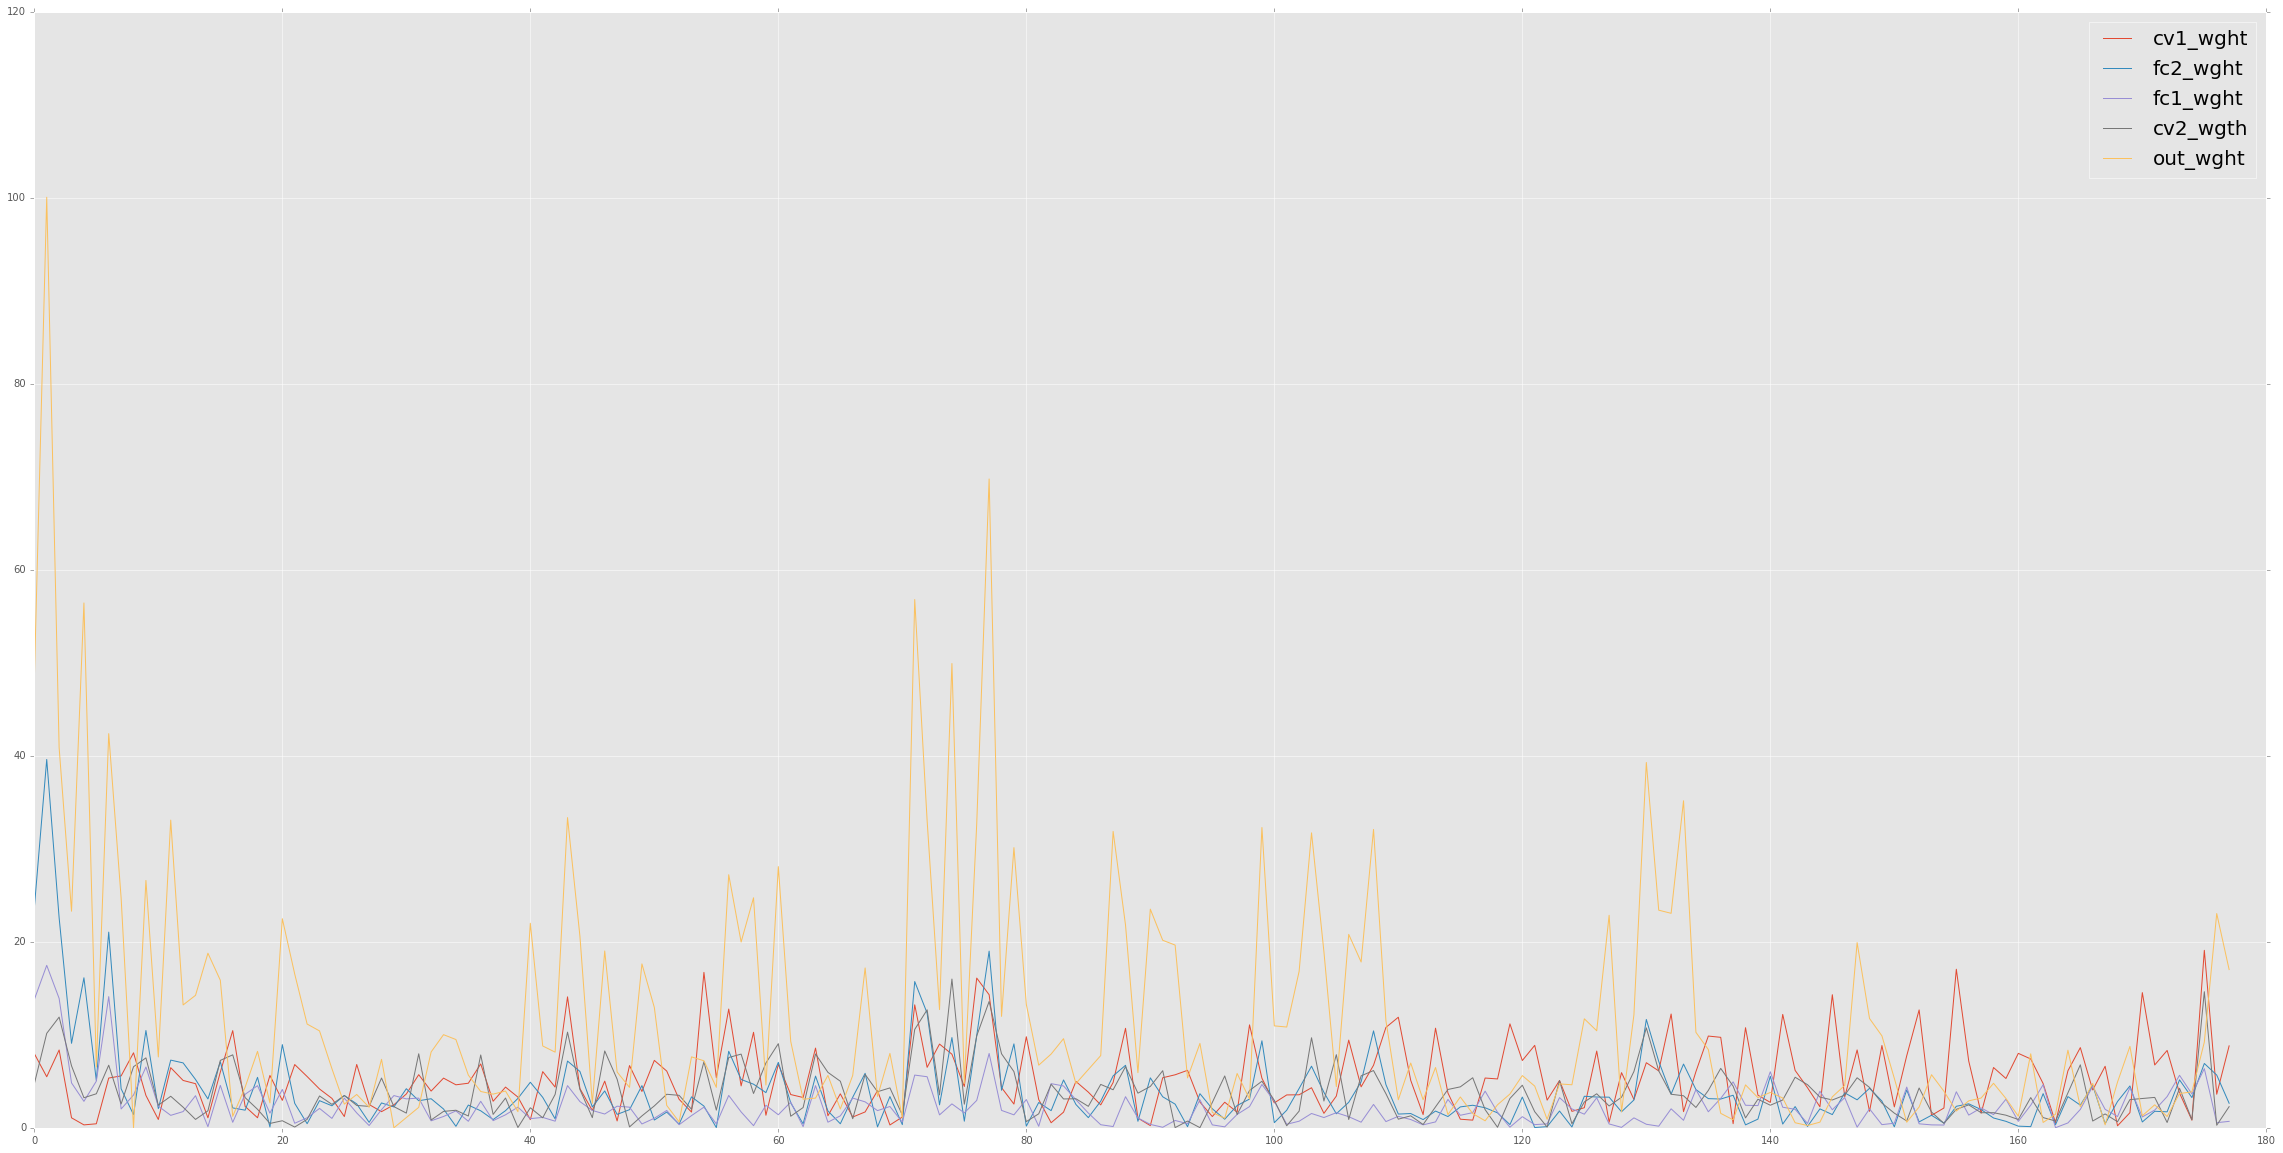

In [26]:
# self.imageSize = 32
# self.seed = 2316                 # Set the seeds for the random weights generator
# self.numFolds = 10

# # Network Parameters
# self.numLabels = 2
# self.numChannel = 1              # numChannels -> For grayscale =1, for RGB =3
# self.numHidden1 = 1024           # numHiddenUnits for the fully connected layerr
# self.numHidden2 = 1024           # numHiddenUnits for the fully connected layer

# self.conv1Kernel = 5             # Size of kernel for the first convolution layer
# self.conv2Kernel = 5             # Size of kernel for the second convolution layer
# self.conv1Depth = 64             # Number of kernels for the first convolution layer
# self.conv2Depth = 64             # Number of kernels for the second convolution layer
# self.conv1Stride = 1             # Strides for the first convolution layer filter  
# self.conv2Stride = 1             # Strides for the second convolution layer filter

# self.pool1Kernel = 2             # Size of kernel for the first Pooling layer
# self.pool2Kernel = 2             # Size of kernel for the second Pooling layer  
# self.pool1Stride = 2             # Strides for the first Pooling layer filter
# self.pool2Stride = 2             # Strides for the second Pooling layer filter

# # Learning Parameters;
# self.alpha = 0.003               # The learning Rate, A high Learning Rate will would be inefficient. If using higher
#                                  # learning rate then use regularizer else, the model will overfitt
# self.dropout = 0.75              # Drop out a weight with a probability
# self.momentum = 0.5              # Momentum for optimization if using momentem if using momentum optimizer

# # Learning Variables     
# self.epochs = 10
# self.batchSize = 256


# Fold: 1, Epoch: 10, Mini Batch: 10, Loss= 13058.341797, Training Accuracy= 81.25000
# Fold: 1, Epoch: 10, Mini Batch: 20, Loss= 8460.974609, Training Accuracy= 85.15625
# Fold: 1, Epoch: 10, Mini Batch: 30, Loss= 9875.975586, Training Accuracy= 87.50000
# Fold: 1, Epoch: 10, Mini Batch: 35, Loss= 7374.078125, Training Accuracy= 85.93750

# Fold: 1, Epoch: 10, Validation Accuracy= 87.80000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          430   52   482
# 1           70  448   518
# All        500  500  1000


ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

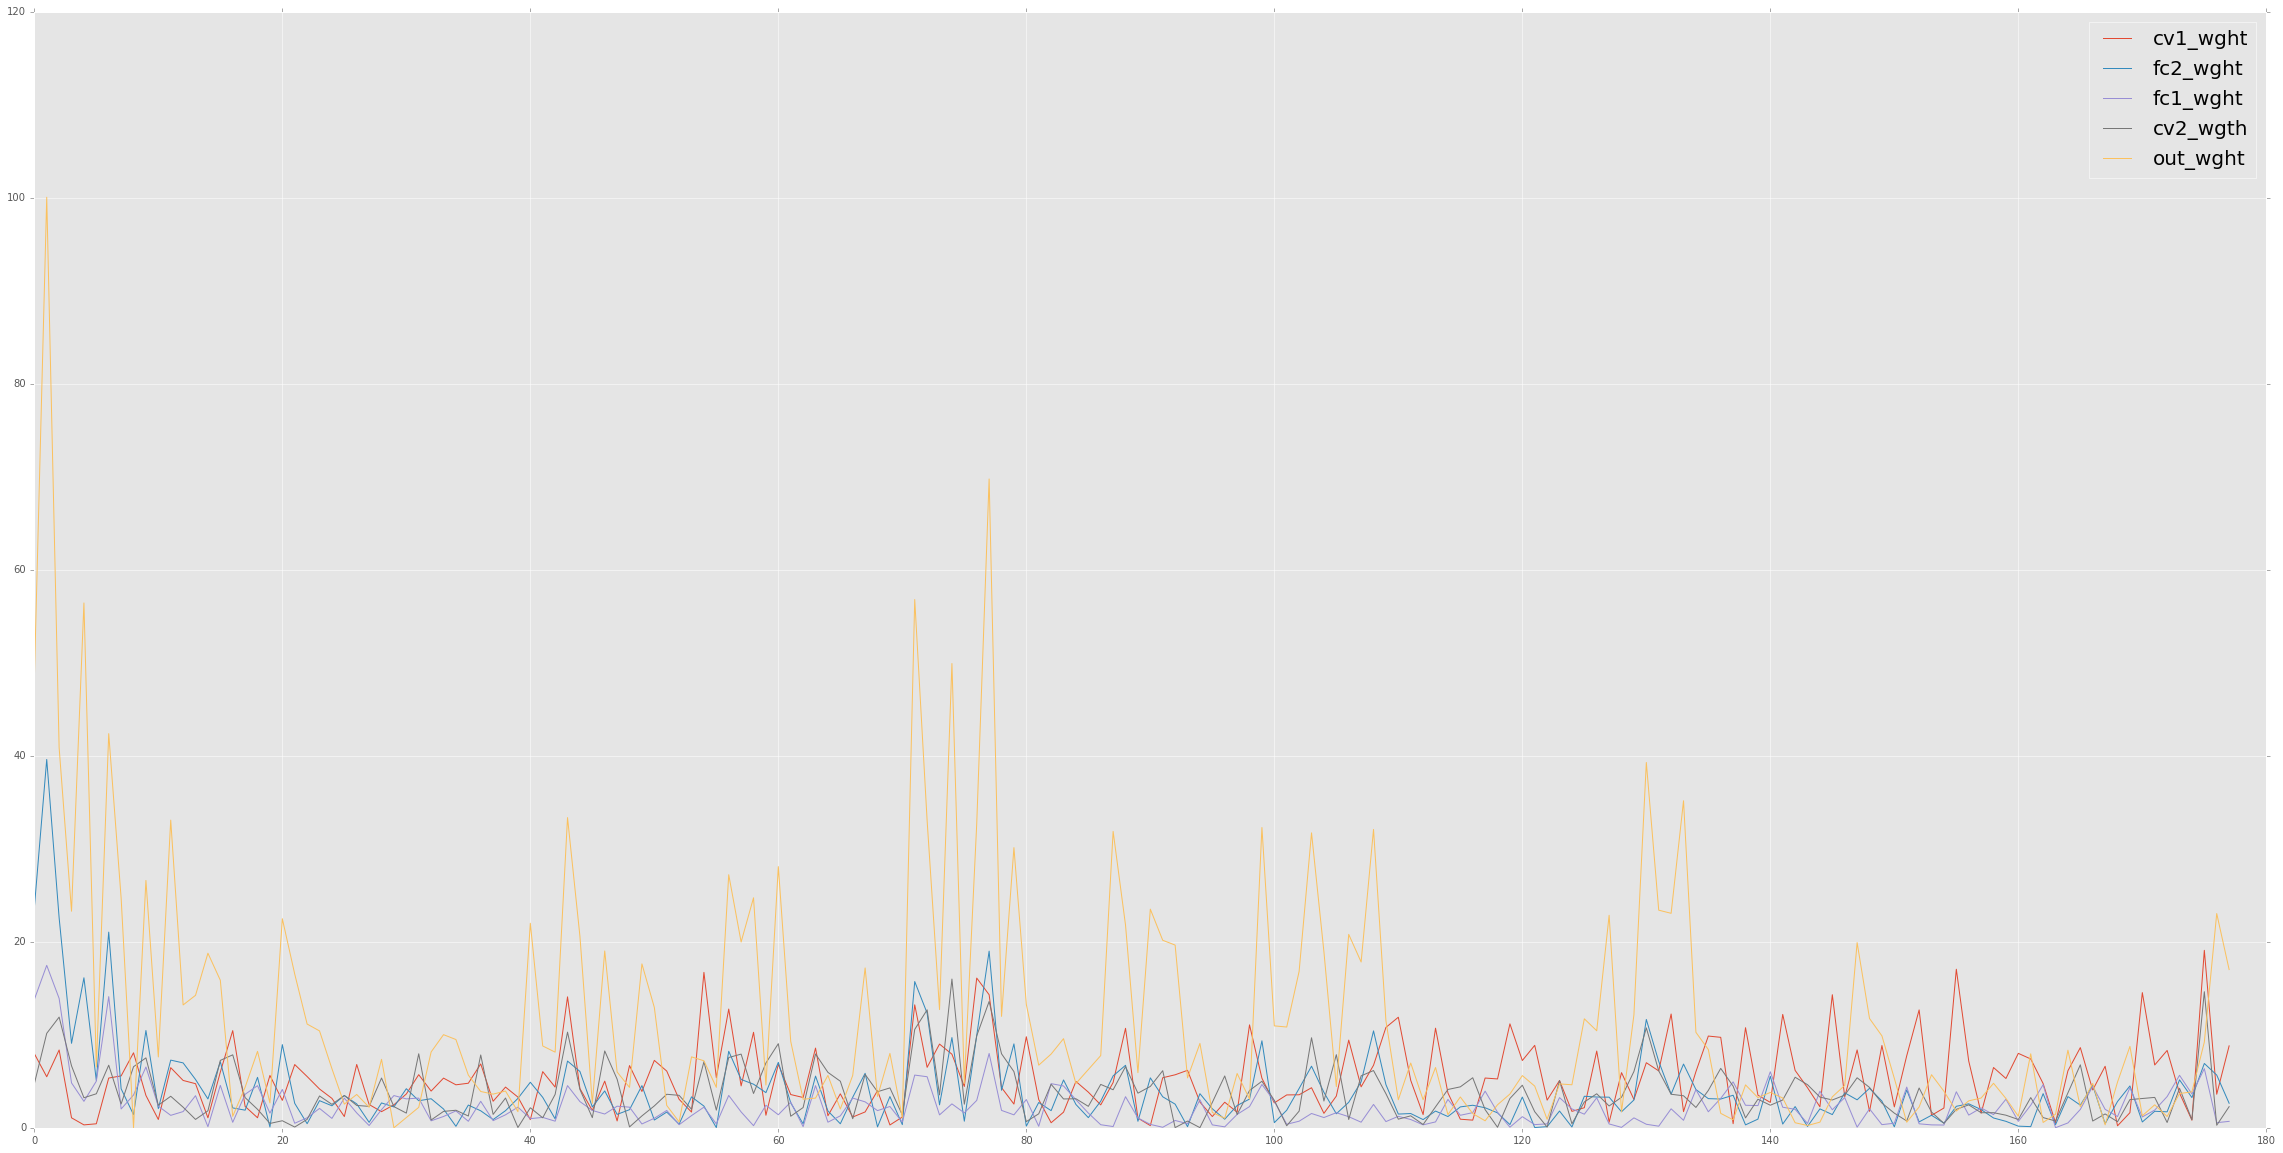

In [27]:
# self.imageSize = 32
# self.seed = 2316                 # Set the seeds for the random weights generator
# self.numFolds = 10

# # Network Parameters
# self.numLabels = 2
# self.numChannel = 1              # numChannels -> For grayscale =1, for RGB =3
# self.numHidden1 = 1024           # numHiddenUnits for the fully connected layerr
# self.numHidden2 = 1024           # numHiddenUnits for the fully connected layer

# self.conv1Kernel = 5             # Size of kernel for the first convolution layer
# self.conv2Kernel = 5             # Size of kernel for the second convolution layer
# self.conv1Depth = 64             # Number of kernels for the first convolution layer
# self.conv2Depth = 64             # Number of kernels for the second convolution layer
# self.conv1Stride = 1             # Strides for the first convolution layer filter  
# self.conv2Stride = 1             # Strides for the second convolution layer filter

# self.pool1Kernel = 2             # Size of kernel for the first Pooling layer
# self.pool2Kernel = 2             # Size of kernel for the second Pooling layer  
# self.pool1Stride = 2             # Strides for the first Pooling layer filter
# self.pool2Stride = 2             # Strides for the second Pooling layer filter

# # Learning Variables     
# self.epochs = 10
# self.batchSize = 256

# Fold: 1, Epoch: 10, Mini Batch: 10, Loss= 11665.839844, Training Accuracy= 83.59375
# Fold: 1, Epoch: 10, Mini Batch: 20, Loss= 7159.013184, Training Accuracy= 87.50000
# Fold: 1, Epoch: 10, Mini Batch: 30, Loss= 11480.009766, Training Accuracy= 87.10938
# Fold: 1, Epoch: 10, Mini Batch: 35, Loss= 7735.696777, Training Accuracy= 89.06250

# Fold: 1, Epoch: 10, Validation Accuracy= 88.00000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          436   56   492
# 1           64  444   508
# All        500  500  1000

# optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0008, momentum=0.8).minimize(lossCE)


ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [28]:
# class BuildConvNet(GlabalVariables):
    
#     def __init__(self):
#         super(BuildConvNet, self).__init__()
        
#         self.weights = {
#             'cv1_wght': tf.Variable(tf.random_normal([self.conv1Kernel, self.conv1Kernel, self.numChannel, self.conv1Depth], seed=8753)),
#             'cv2_wgth': tf.Variable(tf.random_normal([self.conv2Kernel, self.conv2Kernel, self.conv1Depth, self.conv2Depth], seed=3521)),
#             'fc2_wght': tf.Variable(tf.random_normal([self.numHidden1, self.numHidden2], seed=9777)),
#             'out_wght': tf.Variable(tf.random_normal([self.numHidden2, self.numLabels], seed=6467))
#         }

#         self.biases = {
#             'cv1_bias': tf.Variable(tf.random_normal([self.conv1Depth], seed=8767)),
#             'cv2_bias': tf.Variable(tf.random_normal([self.conv2Depth], seed=9887)),
#             'fc1_bias': tf.Variable(tf.random_normal([self.numHidden1], seed=4323)),
#             'fc2_bias': tf.Variable(tf.random_normal([self.numHidden2], seed=4348)),
#             'out_bias': tf.Variable(tf.random_normal([self.numLabels], seed=9878))
#         }


#     def convLayer(self, x, w, b, s=1, nlModel='RELU'):
#         x = tf.nn.conv2d(x, w, [1,s,s,1], padding='SAME') # Same padding
#         x = tf.nn.bias_add(x, b)
#         if nlModel == 'RELU':
#             return tf.nn.relu(x)
#         elif nlModel == 'LOGIT':
#             return tf.sigmoid(x)


#     def poolLayer(self, x, k=2, s=2, poolType='MAX'):
#         if poolType=='MAX':
#             return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')
#         elif poolType == 'AVG':
#             return tf.nn.avg_pool(data, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')

        
#     def fcLayer(self, x, w, b, keepProb=None, nModel='RELU'):
#         x = tf.matmul(x, w) + b
#         if nModel=='RELU':
#             x = tf.nn.relu(x)
#         if nModel=='LOGIT':
#             x = tf.sigmoid(x)
#         if keepProb:
#             return tf.nn.dropout(x, keepProb, seed=6162)
#         else:
#             return x
        
        
#     def outputLayer(self, x, w, b):
#         x = tf.matmul(x, w) + b
#         return x, tf.nn.softmax(x)
    
            
#     # Convolutional Layer (Includes the convLayer and the max pool layer)
#     def convFeatureExtractor(self, x):
#         # Convolution and Pooling Layer 1
#         conv1 = self.convLayer(x, self.weights['cv1_wght'], self.biases['cv1_bias'], s=self.conv1Stride)
#         conv1 = self.poolLayer(conv1, k=self.pool1Kernel)

#         # Convolution and Pooling Layer 2
#         conv2 = self.convLayer(conv1, self.weights['cv2_wgth'], self.biases['cv2_bias'], self.conv2Stride)
#         conv2 = self.poolLayer(conv2, k=self.pool2Kernel)
        
#         # Get the features in flattened fashion
#         poolShape = conv2.get_shape().as_list()[1]
#         numConvFeatures = poolShape*poolShape*self.conv2Depth
#         convFeatures = tf.reshape(conv2, [-1, numConvFeatures])
        
#         return convFeatures, numConvFeatures
        
        
#     # Create the training Graph Lineage
#     def trainGraph(self):
#         trainData = tf.placeholder(tf.float32, [None, self.imageSize, self.imageSize, self.numChannel])
#         trainLabels = tf.placeholder(tf.float32, [None, self.numLabels])

#         # Convolutional Layer
#         convFeatures, numConvFeatures = self.convFeatureExtractor(trainData)
        
#         # Fully connected layer : Reshape conv2 output to fit fully connected layer input
#         self.weights['fc1_wght'] =  tf.Variable(tf.random_normal([numConvFeatures, self.numHidden1], seed=6663))
#         fc1State = self.fcLayer(convFeatures, self.weights['fc1_wght'], self.biases['fc1_bias'], keepProb=0.75, nModel='RELU')
        
#         # Fully connected layer : Layer 2
#         fc2State = self.fcLayer(fc1State, self.weights['fc2_wght'], self.biases['fc2_bias'], keepProb=0.75, nModel='RELU')

#         # Output, or the Softmax layer
#         pred, outputState = self.outputLayer(fc2State, self.weights['out_wght'], self.biases['out_bias'])
        
#         # Loss function and Optimization
#         lossCE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=trainLabels))
# #         optimizer = tf.train.AdamOptimizer(learning_rate=0.003).minimize(lossCE)
#         optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0008, momentum=0.8).minimize(lossCE)

        
#         return dict(
#             trainData=trainData, 
#             trainLabels=trainLabels, 
#             optimizer=optimizer, 
#             lossCE=lossCE,
#             trainPred = outputState,
#             wghtNew = self.weights
#         )
    
    
#     # Create the Validation Graph Lineage
#     def validGraph(self):

#         validData = tf.placeholder(tf.float32, [None, self.imageSize, self.imageSize, self.numChannel])
#         validLabels = tf.placeholder(tf.float32, [None, self.numLabels])

#         # Convolution and Pooling Layer 1
#         vconvFeatures, numConvFeatures = self.convFeatureExtractor(validData)
        
#         # Fully connected layer/Hidden Layer 2 : Reshape conv2 output to fit fully connected layer input
#         vFc1State = self.fcLayer(vconvFeatures, self.weights['fc1_wght'], self.biases['fc1_bias'], nModel='RELU')
        
#         # Fully connected layer/Hidden layer 2
#         vFc2State = self.fcLayer(vFc1State, self.weights['fc2_wght'], self.biases['fc2_bias'], nModel='RELU')


#         # Output Layer or the softmax layer
#         vPred, vOutState = self.outputLayer(vFc2State, self.weights['out_wght'], self.biases['out_bias'])


#         return dict(
#             validData = validData,
#             validLabels = validLabels,
#             validPred = vOutState
#         )



